In [9]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from IPython.core.pylabtools import figsize
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def p_sigmoid(y0,a,T,b,c):
    return y0 + a /(1+np.exp((c-T)/b))


def simulate_data(num_trials, y0, a, t, b, num_bins):
    #let's generate some data and then see how well we can fit it with MCMC


    coherence_bins = np.array(np.linspace(-1, 1, num = num_bins))

    coherences = np.random.choice(coherence_bins, size = num_trials)


    observations = np.random.binomial(1, p_sigmoid(y0, a, t, b, coherences))
    
    return observations, coherences, coherence_bins


observations_s, coherences_s, coherence_bins = simulate_data(num_trials = 400, y0 = .1, a = .8, t = 0, b = .2, num_bins = 10)

In [4]:
def calc_psych_plot(observations, coherences, coherence_bins):

    means = np.array([observations[np.digitize(coherences, coherence_bins + .1) == i].mean() 
                      for i in np.arange(len(coherence_bins))])
    ns = np.array([len(observations[np.digitize(coherences, coherence_bins + .1) == i]) 
                 for i in np.arange(len(coherence_bins))])
    
    std = np.sqrt(means*(1-means) / ns)
    
    return means, std

means, std = calc_psych_plot(observations_s, coherences_s, coherence_bins)

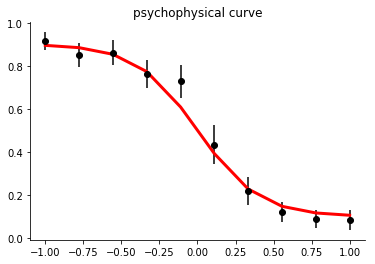

In [4]:
ax = plt.subplot(111)
plt.plot(coherence_bins, p_sigmoid(.1, .9, 0, .2, coherence_bins), c = 'r', linewidth = 3)
plt.errorbar(coherence_bins,*calc_psych_plot(observations_s, coherences_s, coherence_bins), c = 'k', fmt = 'o')

plt.title('psychophysical curve')
simpleaxis(ax)

In [15]:



def simple_psych_model(coherences, observations):

    with pm.Model() as simple_model:
        #y0_ = pm.Uniform("y0",0,1)
        #a_ = pm.Uniform("a",0,1-y0_)
        #T_ = pm.Uniform("T",-1,1)
        #b_ = pm.Uniform("b",-1,1)

        y0 = pm.distributions.continuous.Beta("y0", alpha = 2, beta = 10)
        a = pm.distributions.continuous.Beta("a", alpha = 10, beta = 2)
        BoundedNormal = pm.Bound(pm.Normal, lower = -1, upper = 1)
        T = BoundedNormal("T", mu = 0, sd = .2)   
        b = pm.distributions.continuous.Beta("b", alpha = 2, beta = 10)
        
        
        theta_ = y0 + a * tt.nnet.nnet.sigmoid(-(coherences-T)/b)    
        theta = pm.Deterministic("theta",theta_)

        NR = pm.Bernoulli("NR",theta,observed=observations)
        
    return simple_model


simple_model = simple_psych_model(coherences_s, observations_s)

with simple_model:
    step = pm.Metropolis()
    simple_trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 15000/15000 [00:12<00:00, 1189.74it/s]


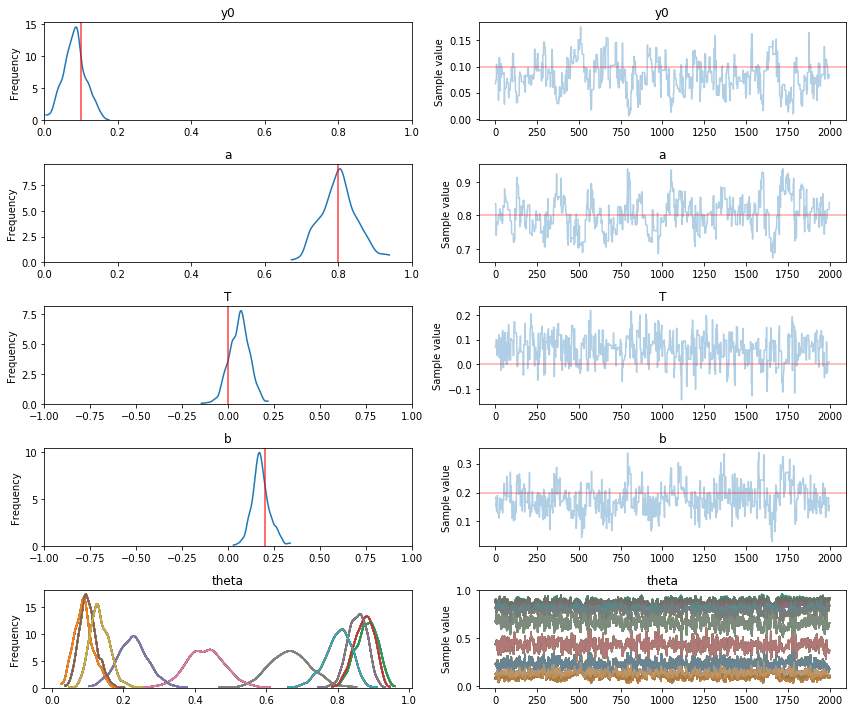

In [16]:
from IPython.core.pylabtools import figsize

figsize(12, 10)
figs,ax = plt.subplots(5, 2)

_ = pm.traceplot(simple_trace[-2000:], ax = ax, lines = {"y0": .1, "a": .8, "T": 0, "b": .2} )

ax[0, 0].set_xlim([0, 1])
ax[1, 0].set_xlim([0, 1])
ax[2, 0].set_xlim([-1, 1])
ax[3, 0].set_xlim([-1, 1])
plt.tight_layout()

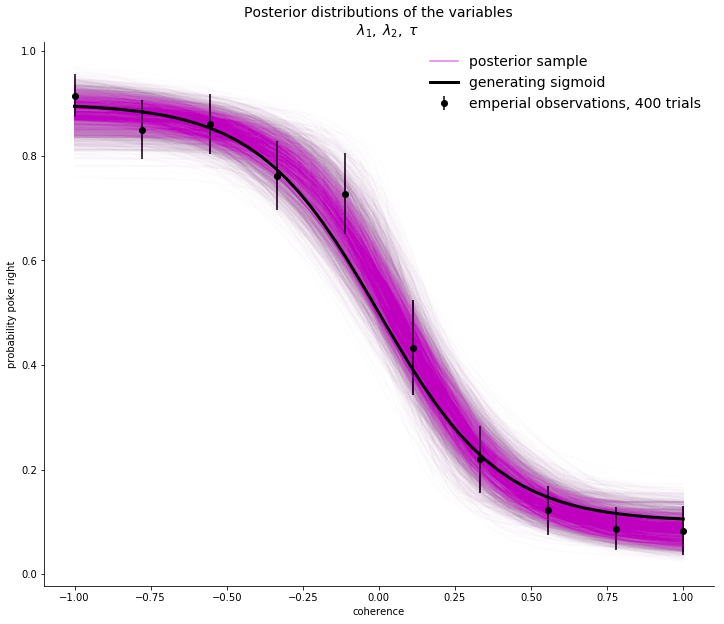

In [17]:
T_traces = simple_trace['T']
a_traces = simple_trace['a']
y0_traces = simple_trace['y0']
b_traces = simple_trace['b']

plt.figure(figsize = [12, 10])
c = np.linspace(-1,1)

ax = plt.subplot(111)

for i in range(6000,9999):
    plt.plot(c, p_sigmoid(y0_traces[i],a_traces[i],T_traces[i], b_traces[i],c),alpha=0.0075,c='m')

plt.plot(c, p_sigmoid(y0_traces[i-500],a_traces[i-500],T_traces[i-500], b_traces[i-500],c),alpha=.5,c='m', label = "posterior sample")

plt.plot(c, p_sigmoid(.1, .8, 0, .2, c),'k-', linewidth = 3, label= "generating sigmoid")
plt.errorbar(coherence_bins, *calc_psych_plot(observations_s, coherences_s, coherence_bins), 
             c = 'k', fmt = 'o', label = "emperial observations, 400 trials")
    
    
plt.legend(loc="upper right", frameon = False, fontsize = 14)
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""", fontdict = {'fontsize': 14})
#plt.xlim([-1,1 ])
#plt.xlabel("$\lambda_1$ value")
plt.ylabel("probability poke right")
plt.xlabel("coherence")


simpleaxis(ax)

In [41]:
#now let's simulate data from the switching model. We're doing this brute force for today

#let's generate some data and then see how well we can fit it with MCMC

import pymc3 as pm
import theano.tensor as tt

obs1, coher1, coherence_bins = simulate_data(num_trials = 500, y0 = .1, a = .9, t = .4, b = .1, num_bins = 10)

obs2, coher2, _ = simulate_data(num_trials = 500, y0 = .1, a = .9, t = -.4, b = .1, num_bins = 10)


coherences_sw = np.hstack((coher1, coher2))
observations_sw = np.hstack((obs1, obs2))


In [42]:
coher1 = coherences_sw[0:500]
coher2 = coherences_sw[500:]
obs1 = observations_sw[0:500]
obs2 = observations_sw[500:]

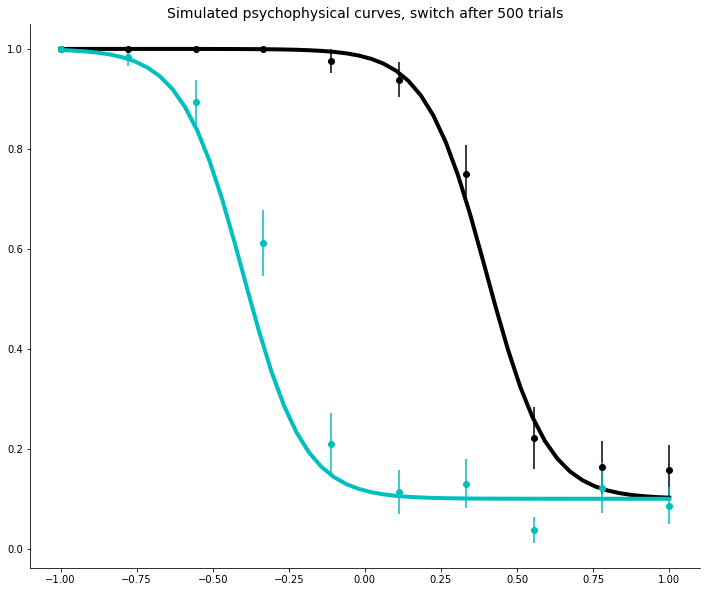

In [43]:
ax = plt.subplot(111)
plt.plot(c, p_sigmoid(.1, .9, .4, .1, c), c = 'k', linewidth = 4)
plt.errorbar(coherence_bins, *calc_psych_plot(obs1, coher1, coherence_bins), c = 'k', fmt = 'o')


plt.plot(c, p_sigmoid(.1, .9, -.4, .1, c), c = 'c', linewidth = 4)
plt.errorbar(coherence_bins, *calc_psych_plot(obs2, coher2, coherence_bins), c = 'c', fmt = 'o')


plt.title('Simulated psychophysical curves, switch after 500 trials', fontsize = 14)
simpleaxis(ax)


In [22]:
simple_model2 = simple_psych_model(coherences_sw, observations_sw)

with simple_model2:
    step = pm.Metropolis()
    simple_trace2 = pm.sample(10000, tune=5000,step=step)

100%|██████████| 15000/15000 [00:18<00:00, 810.19it/s]


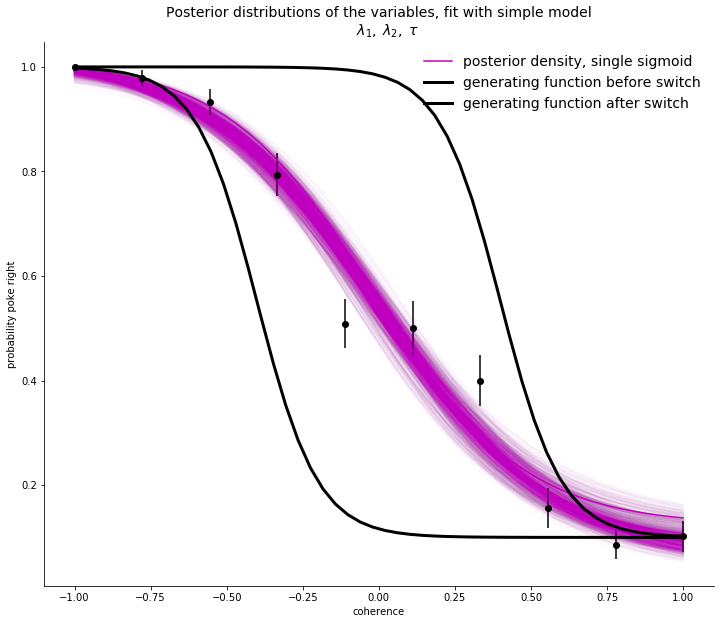

In [23]:
T_traces = simple_trace2['T']
a_traces = simple_trace2['a']
y0_traces = simple_trace2['y0']
b_traces = simple_trace2['b']

plt.figure(figsize = [12, 10])
c = np.linspace(-1,1)
ax = plt.subplot(111)



for i in range(8000,9999):
    plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],c),alpha=0.01,c='m')

plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],c),
         alpha=1,c='m',label = "posterior density, single sigmoid")

plt.plot(c, p_sigmoid(.1, .9, -.4, .1, c), c = 'k', linewidth = 3, label = "generating function before switch")
plt.plot(c, p_sigmoid(.1, .9, .4, .1, c), c = 'k', linewidth = 3, label = "generating function after switch")




plt.errorbar(coherence_bins, *calc_psych_plot(observations_sw, coherences_sw, coherence_bins), c = 'k', fmt = 'o')
plt.xlabel("coherence")    
plt.ylabel("probability poke right") 

plt.legend(loc="upper right", frameon = False, fontsize = 14)
plt.title(r"""Posterior distributions of the variables, fit with simple model
    $\lambda_1,\;\lambda_2,\;\tau$""", fontsize = 14)
#plt.xlim([-1,1 ])


simpleaxis(ax)

In [44]:
def Switching_Model(observations, coherences, num_trials):
    time = np.arange(0, 2*num_trials)
    with pm.Model() as switching_model:
        BoundedNormal = pm.Bound(pm.Normal, lower = -1, upper = 1)
        #model before 1st switch

        y0 = pm.distributions.continuous.Beta("y0", alpha = 2, beta = 10)
        a = pm.distributions.continuous.Beta("a", alpha = 10, beta = 2)
        T = BoundedNormal("T", mu = .4, sd = .2)   
        b = pm.distributions.continuous.Beta("b", alpha = 2, beta = 10)

        #model after 1st switch


        y0_1 = pm.distributions.continuous.Beta("y0_1", alpha = 2, beta = 10)
        a_1 = pm.distributions.continuous.Beta("a_1", alpha = 10, beta = 2)
        T_1 = BoundedNormal("T1", mu = -.4, sd = .2)   
        b_1 = pm.distributions.continuous.Beta("b_1", alpha = 2, beta = 10)


        s1 = pm.DiscreteUniform('switchpoint1',300, 800, testval = 500)

        tau_y1 = pm.math.switch(time >= s1, y0_1, y0)    
        tau_a1 = pm.math.switch(time >= s1, a_1, a) 
        tau_T1 = pm.math.switch(time >= s1, T_1, T) 
        tau_b1 = pm.math.switch(time >= s1, b_1, b) 


        theta_ = y0 + a * tt.nnet.nnet.sigmoid(-(coherences-tau_T1)/tau_b1)    
        theta = pm.Deterministic("theta",theta_)


        NR = pm.Bernoulli("NR",theta,observed=observations)
        
    return switching_model

switching_model = Switching_Model(observations_sw, coherences_sw, 500)

with switching_model:
    #step = pm.NUTS()
    switching_trace = pm.sample(100000, tune=5000)

Assigned NUTS to y0_logodds__
Assigned NUTS to a_logodds__
Assigned NUTS to T_interval__
Assigned NUTS to b_logodds__
Assigned NUTS to y0_1_logodds__
Assigned NUTS to a_1_logodds__
Assigned NUTS to T1_interval__
Assigned NUTS to b_1_logodds__
Assigned Metropolis to switchpoint1
100%|█████████▉| 104966/105000 [07:27<00:00, 156.58it/s]/usr/local/lib/python2.7/dist-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.617446892526, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/python2.7/dist-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 98464 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 105000/105000 [07:28<00:00, 234.37it/s]


(-1, 1)

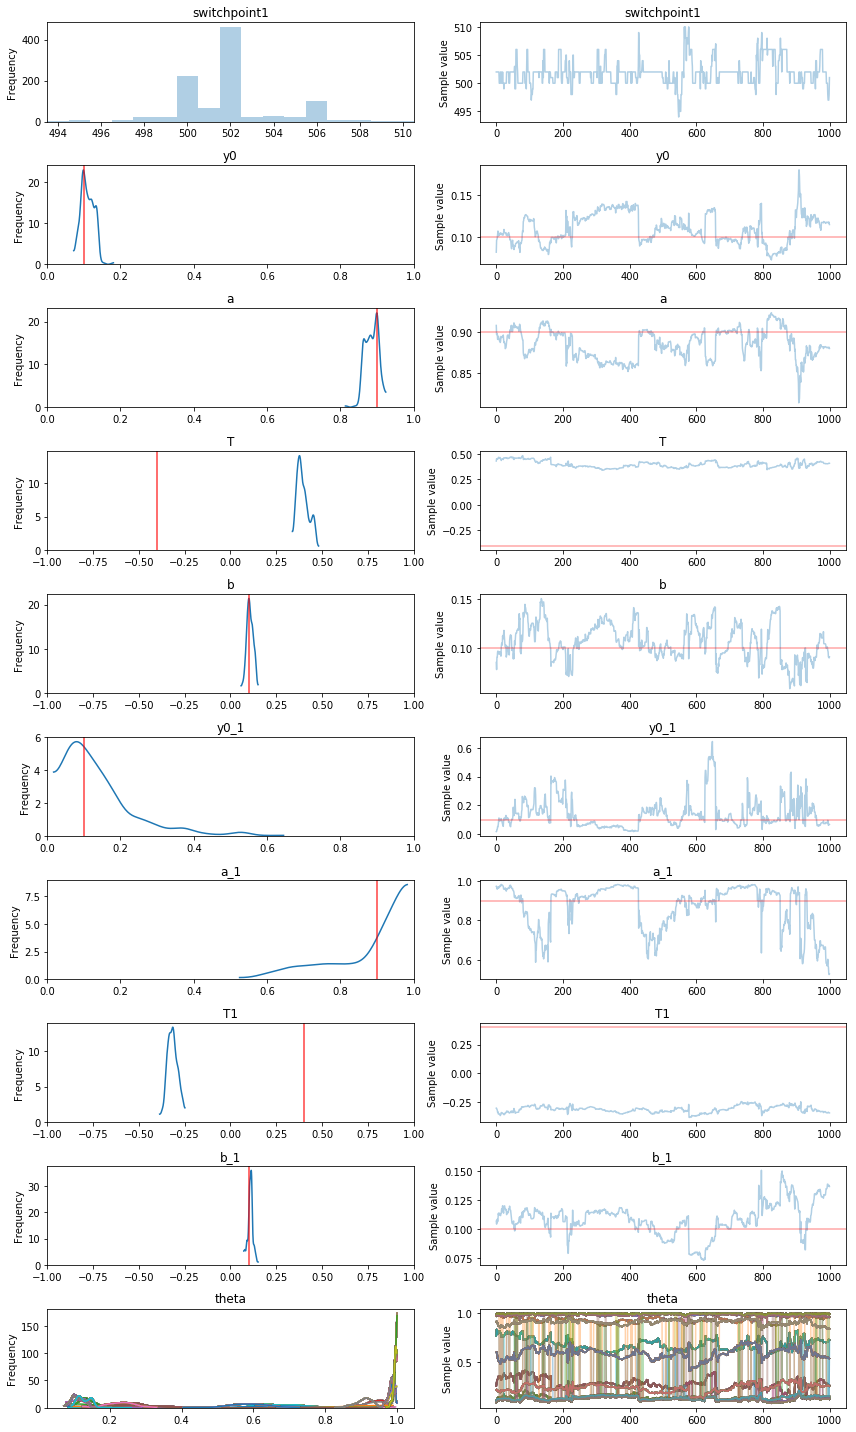

In [47]:
ax = pm.traceplot(switching_trace[-1000:], lines = {
        "switchpoint":500,"y0": .1, "a": .9, "T": -.4, "b": .1, "y0_1": .1, "a_1":.9, "T1":.4, "b_1": .1})
ax[1, 0].set_xlim([0, 1])
ax[2, 0].set_xlim([0, 1])
ax[3, 0].set_xlim([-1, 1])
ax[4, 0].set_xlim([-1, 1])
ax[5, 0].set_xlim([0, 1])
ax[6, 0].set_xlim([0, 1])
ax[7, 0].set_xlim([-1, 1])
ax[8, 0].set_xlim([-1, 1])

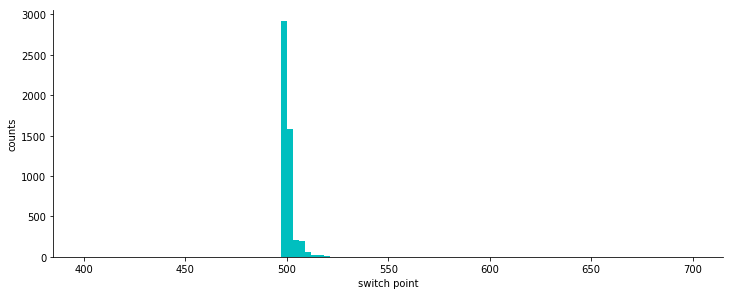

In [87]:
ax = plt.subplot(211)
plt.hist(switching_trace['switchpoint1'][-5000:], bins= np.linspace(400, 700,num = 100), color = 'c');
simpleaxis(ax)
plt.ylabel("counts")
plt.xlabel("switch point")

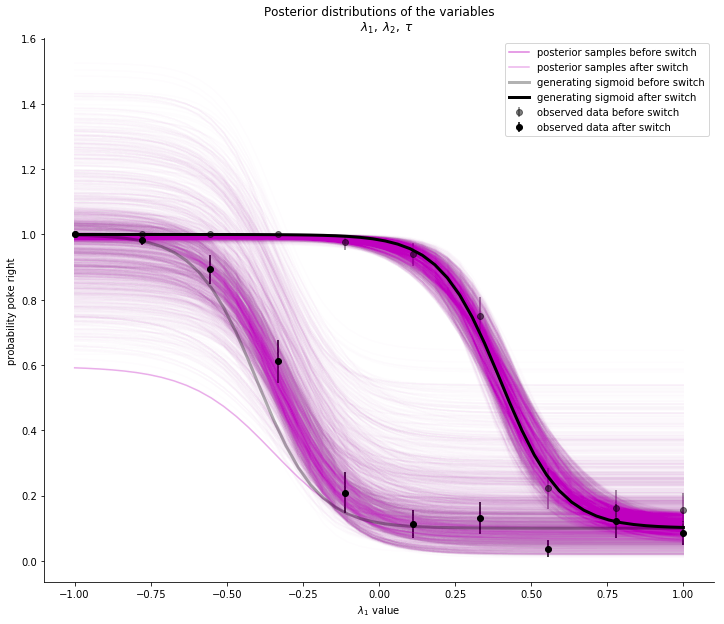

In [48]:
T_traces = switching_trace['T']
a_traces = switching_trace['a']
y0_traces = switching_trace['y0']
b_traces = switching_trace['b']

plt.figure(figsize = [12, 10])
c = np.linspace(-1,1)
ax = plt.subplot(111)


for i in np.arange(len(T_traces)- 2000, len(T_traces)):
    plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],c),alpha=0.01,c='m')
plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],c),
         alpha=0.5,c='m', label = "posterior samples before switch")

T_traces = switching_trace['T1']
a_traces = switching_trace['a_1']
y0_traces = switching_trace['y0_1']
b_traces = switching_trace['b_1']


for i in np.arange(len(T_traces)- 2000, len(T_traces)):
    plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],c),alpha=0.01,c='m')

plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],c),
         alpha=.3,c='m',label = "posterior samples after switch")        
    

plt.plot(c, p_sigmoid(.1, .9, -.4, .1, c), c = 'k', alpha = .3, linewidth = 3, label = "generating sigmoid before switch")
plt.plot(c, p_sigmoid(.1, .9, .4, .1, c), c = 'k', linewidth = 3, label = "generating sigmoid after switch")



plt.errorbar(coherence_bins, *calc_psych_plot(obs1,coher1,coherence_bins), c = 'k', fmt = 'o', alpha = .5, label = "observed data before switch")
plt.errorbar(coherence_bins, *calc_psych_plot(obs2,coher2,coherence_bins), c = 'k', fmt = 'o', label = "observed data after switch")

plt.xlabel('coherence')
plt.ylabel('probability poke right')

plt.title('simulated psychophysical curve')
simpleaxis(ax)
    
    
plt.legend(loc="upper right")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([-1,1 ])
plt.xlabel("$\lambda_1$ value")

simpleaxis(ax)

In [33]:
df_comp_WAIC = pm.compare((simple_trace2[-1000:], switching_trace[-1000:]), (simple_model2, switching_model))
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,539.96,5.79,0,1,34.95,0,1
0,827.3,2.46,287.34,0,32.64,26.16,0


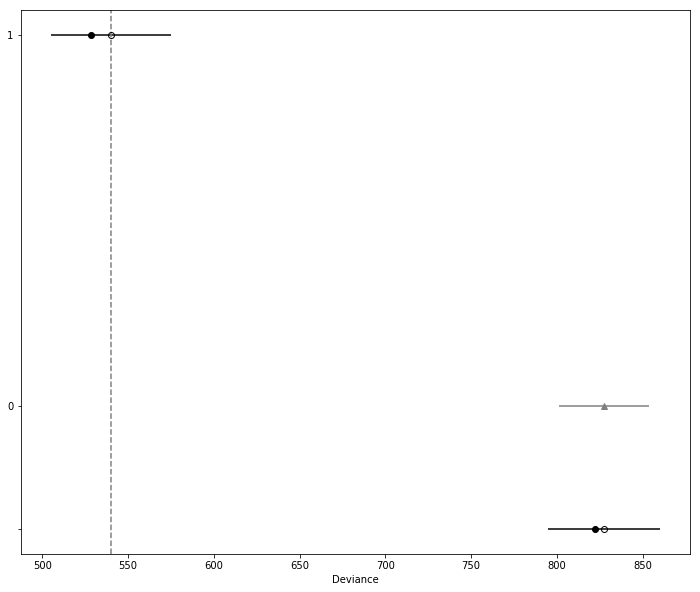

In [34]:
pm.compareplot(df_comp_WAIC);

In [35]:
simple_loo = pm.loo(simple_trace2[-1000:], simple_model)
switching_loo = pm.loo(switching_trace[-1000:], switching_model)

/usr/local/lib/python2.7/dist-packages/pymc3/stats.py:284: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


In [36]:
simple_loo

LOO_r(LOO=393.80227884534349, LOO_se=37.40110399342813, p_LOO=11.360849619460282)

In [37]:
switching_loo

LOO_r(LOO=539.85291474920609, LOO_se=34.940065857884683, p_LOO=5.7435614441578764)

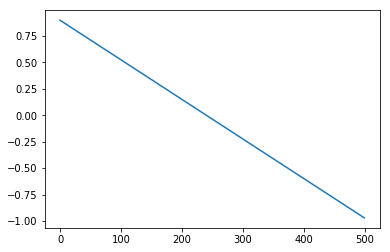

In [5]:
from scipy.stats import norm

#now let's generate data from a time-evolving threshold

num_trials = 500

time = np.arange(num_trials)

threshold = .9 - .00375*time

plt.plot(threshold)

In [6]:
y01 = .1
a1 = .9
b1 = .1

#psych = lambda coherences, threshold: y01 + (a1/(1+np.exp(-(coherences-threshold)/b1)))

coherences_gp = np.random.choice(coherence_bins, size = num_trials)
observations_gp = np.random.binomial(1, p_sigmoid(y01, a1, threshold, b1, coherences_gp))

NameError: name 'c' is not defined

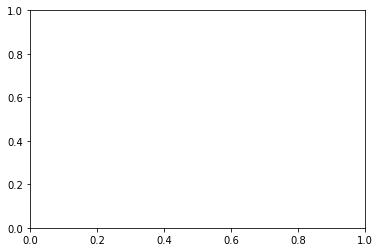

In [7]:
ax = plt.subplot(111)

for i in range(num_trials):
    plt.plot(c, p_sigmoid(y01, a1, threshold[i], b1, c), c = 'r', alpha = .1)
    
plt.plot(c, p_sigmoid(y01, a1, threshold[i], b1, c), c = 'r', alpha = 1, label = "Generating psychophysical curve")    
    

plt.errorbar(coherence_bins, *calc_psych_plot(observations_gp, coherences_gp, coherence_bins), 
             c = 'k', fmt = 'o', label = 'Observed data')
plt.xlabel('coherence')
plt.ylabel('probability poke right')

plt.title('psychophysical curve, changing threshold over time')
simpleaxis(ax)


In [ ]:
def GP_Model(coherences, observations, num_trials):
    with pm.Model() as GP_model:
        y0 = pm.Uniform("y0",0,1)
        a = pm.Uniform("a",0,1-y0)
        b = pm.Uniform("b",-10,10)


        #for gaussian process
        l = pm.Uniform('l', 50, 900)
        #l = 100

        # uninformative prior on the function variance
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))

        # uninformative prior on the noise variance
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

        # covariance functions for the function f and the noise
        f_cov =  s2_f* pm.gp.cov.ExpQuad(1, l)


        g_p = pm.gp.Latent(cov_func=f_cov)

        f = g_p.prior("f", X = time[:, None] )

        thresh = pm.Normal("thresh", mu = f, sd = s2_n, shape = num_trials)

        theta_ = y0 + a * tt.nnet.nnet.sigmoid((coherences-thresh)/b) 
        theta = pm.Deterministic("theta",theta_)
        NR = pm.Bernoulli("NR",theta,observed=observations)
        
    return GP_model

GP_model = GP_Model(coherences_gp, observations_gp, num_trials)

with GP_model:
    step = pm.Metropolis()
    GP_trace = pm.sample(10000, tune=1000,step=step)   

  1%|          | 63/11000 [00:09<26:59,  6.75it/s]

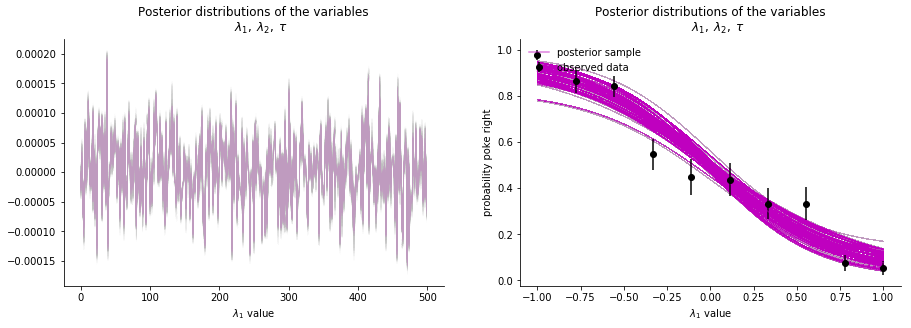

In [28]:
#T_traces = trace['T']
a_traces = GP_trace['a']
y0_traces = GP_trace['y0']
b_traces = GP_trace['b']
thresh_traces = GP_trace['thresh']

figsize(15, 10)
c = np.linspace(-1,1)
ax = plt.subplot(221)



for i in np.arange(len(GP_trace) - 100, len(GP_trace)):
    plt.plot(thresh_traces[i],alpha=0.005,c='m')

plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([-1,1 ])
plt.xlabel("$\lambda_1$ value")


simpleaxis(ax)

figsize(15, 10)
c = np.linspace(-1,1)
ax = plt.subplot(222)



for i in range(len(GP_trace) - 100, len(GP_trace)):
    for j in np.arange(0, num_trials, 5):
        plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],thresh_traces[i, j],-b_traces[i],c),alpha=0.005,c='m')


plt.plot(c,p_sigmoid(y0_traces[i],a_traces[i],thresh_traces[i, j],-b_traces[i],c),alpha=0.5,c='m',label = "posterior sample")
plt.errorbar(coherence_bins, *calc_psych_plot(observations_gp, coherences_gp, coherence_bins), c = 'k', fmt = 'o', label = "observed data")
plt.xlabel('coherence')
plt.ylabel('probability poke right')

plt.legend(loc="upper left", frameon = False)
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([-1,1 ])
plt.xlabel("$\lambda_1$ value")


simpleaxis(ax)

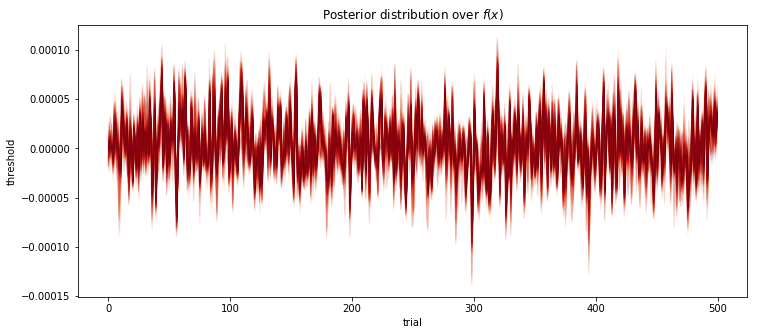

In [25]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, GP_trace["f"], np.arange(num_trials));

# axis labels and title
plt.xlabel("trial"); plt.ylabel("threshold");
plt.title("Posterior distribution over $f(x)$"); plt.legend();

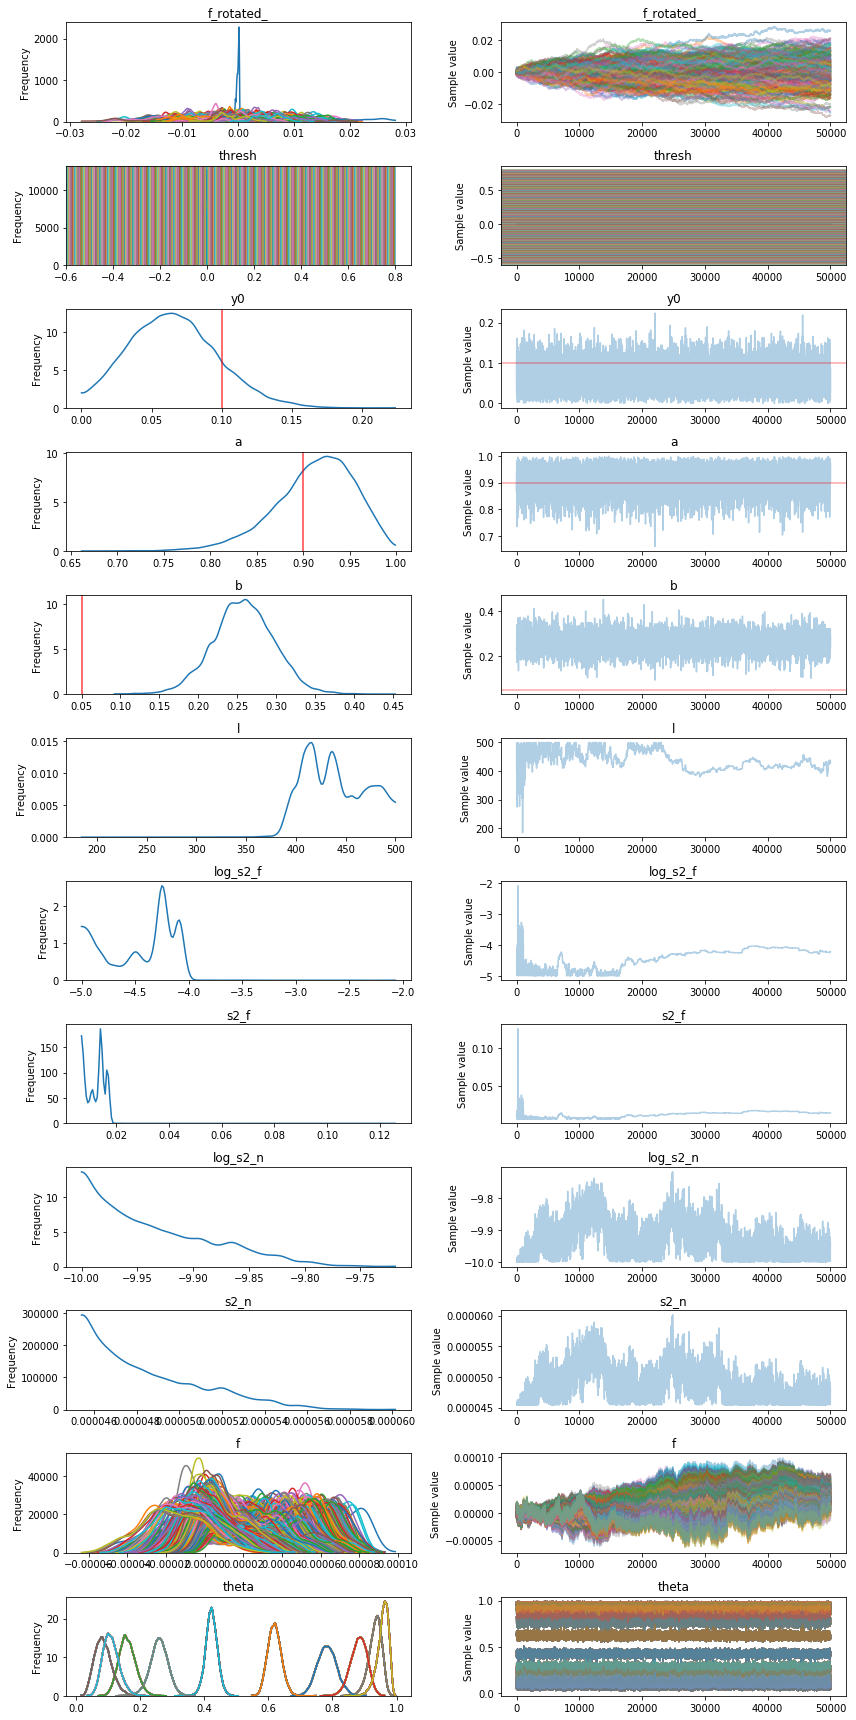

In [217]:
_ = pm.traceplot(GP_trace,              
                 lines={"y0": y01,
                    "a": a1,
                    "b": b1, 
                    "thresh": threshold})

In [27]:
simple_model3 = simple_psych_model(coherences_gp, observations_gp)

with simple_model3:
    step = pm.Metropolis()
    simple_trace3 = pm.sample(10000, tune=5000,step=step)

100%|██████████| 15000/15000 [00:12<00:00, 1215.25it/s]


In [ ]:
T_traces = simple_trace3['T']
a_traces = simple_trace3['a']
y0_traces = simple_trace3['y0']
b_traces = simple_trace3['b']

plt.figure(figsize = [12, 10])
c = np.linspace(-1,1)

ax = plt.subplot(111)

for i in range(6000,9999):
    plt.plot(c, p_sigmoid(y0_traces[i],a_traces[i],T_traces[i], b_traces[i],c),alpha=0.0075,c='m')

plt.plot(c, p_sigmoid(y0_traces[i-500],a_traces[i-500],T_traces[i-500], b_traces[i-500],c),alpha=.5,c='m', label = "posterior sample")

plt.plot(c, p_sigmoid(.1, .8, 0, .2, c),'k-', linewidth = 3, label= "generating sigmoid")
plt.errorbar(coherence_bins, *calc_psych_plot(observations_gp, coherences_gp, coherence_bins), 
             c = 'k', fmt = 'o', label = "emperial observations")
    
    
plt.legend(loc="upper right", frameon = False, fontsize = 14)
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""", fontdict = {'fontsize': 14})
#plt.xlim([-1,1 ])
#plt.xlabel("$\lambda_1$ value")
plt.ylabel("probability poke right")
plt.xlabel("coherence")


simpleaxis(ax)

In [11]:
def RW_Model(coherences, observations, num_trials, subsample_n = 50):
    lendata = len(coherences)
    ncoef = lendata // subsample_n
    idx = range(ncoef*subsample_n)
    
    with pm.Model() as RW_model:
        sigma_theta = pm.Exponential('sigma_theta', 1./.02, testval = .1)
        
        
        y0 = pm.distributions.continuous.Beta("y0", alpha = 2, beta = 10)
        a = pm.distributions.continuous.Beta("a", alpha = 10, beta = 2) 
        b = pm.distributions.continuous.Beta("b", alpha = 2, beta = 10)


        thresh = pm.GaussianRandomWalk("thresh", sigma_theta**-2, shape = ncoef)
        
        thresh_r = tt.repeat(thresh, subsample_n)

        theta_ = y0 + a * tt.nnet.nnet.sigmoid((coherences-thresh_r)/b) 
        theta = pm.Deterministic("theta",theta_)
        NR = pm.Bernoulli("NR",theta,observed=observations)
        
    return RW_model

RW_model = RW_Model(coherences_gp, observations_gp, num_trials)

with RW_model:
    RW_trace = pm.sample(10000, tune=1000)   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 10921/11000 [00:34<00:00, 872.83it/s]/usr/local/lib/python2.7/dist-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.36117274644, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/python2.7/dist-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3727 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 11000/11000 [00:34<00:00, 314.78it/s]


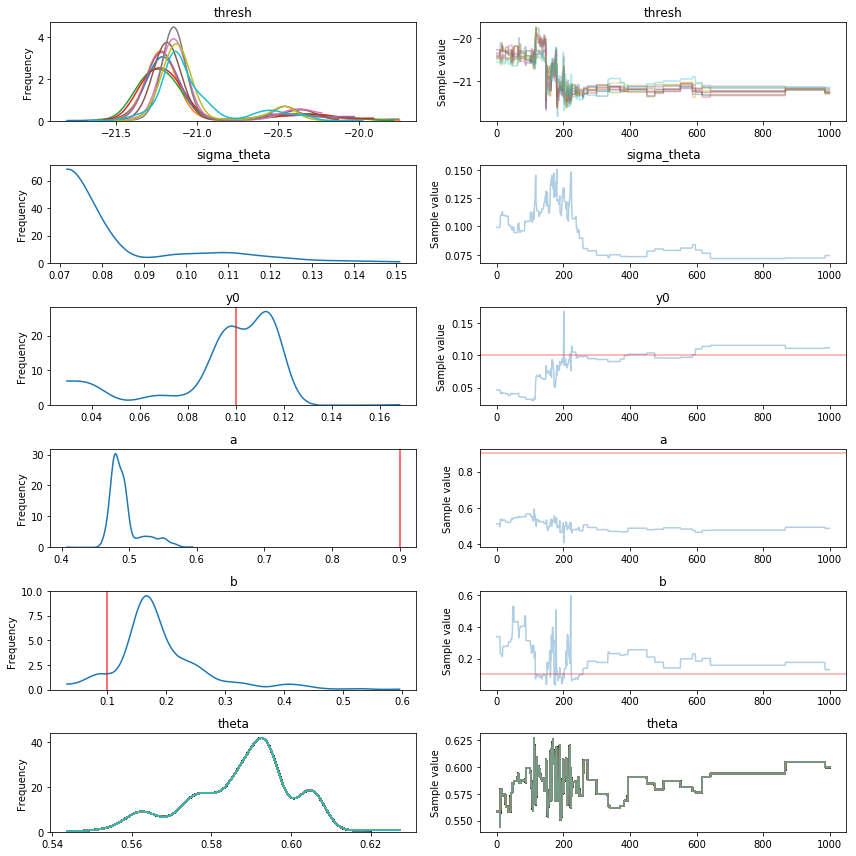

In [13]:
_ = pm.traceplot(RW_trace[-1000:],              
                 lines={"y0": y01,
                    "a": a1,
                    "b": b1})

In [14]:
RW_trace['thresh'].shape

(10000, 10)

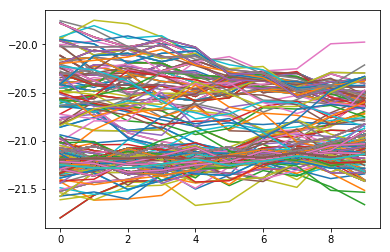

In [18]:
plt.plot(RW_trace['thresh'][-1000:, :].T);